<a href="https://colab.research.google.com/github/vitalns/clasterization/blob/main/clasterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
<font size="5" color="blue">Кластеризация</font>
<font size="5"> &#128450 </font>
</div>

На примере датасета "penguins" рассмотрены методы кластеризации:

- <p><b><i>Метод к-средних (KMeans);</i></b>
- <p><b><i>KMeans совместо с методом уменьшения размерности данных t_SNE;</i></b>
- <p><b><i>Агломеративный метод (Hierarchical agglomerative clustering);</i></b>
- <p><b><i>DBSCAN (Density-based spatial clustering of applications with noise).</i></b>

Также представлена визуализация, расчёт многоклассовых метрик accuracy, precision, recall, F1 и сравнение результатов.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple
from itertools import permutations

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import (KMeans,
                             DBSCAN,
                             AgglomerativeClustering)
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score)
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter("ignore", category=SettingWithCopyWarning)

# *Анализ данных*

## Предобработка данных

In [ ]:
# Загрузим датасет

penguins = sns.load_dataset("penguins")
penguins.dropna(inplace=True)
penguins.reset_index(drop=True, inplace=True)
penguins.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female


In [ ]:
# Разделим числовые и категориальные данные
penguins_data = penguins.select_dtypes(np.number)
penguins_info = penguins.select_dtypes(exclude='float')

In [ ]:
# Создадим таблицу со средними значениями.

species = penguins.species.unique()

try:
  averages = [penguins[penguins['species']==i].mean().to_list() for i in species] # Раньше так работало
except:
  # mean применяем толко к слобцам с числовыми данными
  averages = [penguins[penguins['species']==i][penguins.select_dtypes(np.number).columns].mean().to_list() for i in species]

avg_data = pd.DataFrame(averages, columns=penguins.select_dtypes(np.number).columns)
avg_data['species'] = species

# Добавим средние значения к общей таблице.
avg = avg_data.copy(deep=True)
avg.species = 'mean' # Добавляем заглушку для hue в pairgrid.
data_all = pd.concat([penguins, avg], ignore_index=True)
data_all.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
331,Gentoo,Biscoe,45.200000,14.800000,212.000000,5200.000000,Female
332,Gentoo,Biscoe,49.900000,16.100000,213.000000,5400.000000,Male
333,mean,NaN,38.823973,18.347260,190.102740,3706.164384,NaN
334,mean,NaN,48.833824,18.420588,195.823529,3733.088235,NaN
335,mean,NaN,47.568067,14.996639,217.235294,5092.436975,NaN


---

## Масштабирование данных

In [ ]:
# Масштабируем данные.
data_scaled = StandardScaler().fit_transform(penguins_data)

# Собирём таблицу с масштабированными данными и добавим столбец 'species'.
data_sc = pd.DataFrame(data_scaled, columns=penguins_data.columns)
data_sc['species'] = penguins.species.tolist()

# Вычислим средние значения.
try:
  averages_sc = [data_sc[data_sc['species']==i].mean().to_list() for i in species] # Раньше работало и автоматически отбрасывались строковые переменные
except:
  # mean применяем толко к слобцам с числовыми данными
  averages_sc = [data_sc[data_sc['species']==i][data_sc.select_dtypes(np.number).columns].\
                                                                mean().to_list() for i in species]
# Собирём таблицу с масштабированными средними значениями и добавим столбец 'species'.
avg_data_sc = pd.DataFrame(averages_sc, columns=penguins_data.columns)
avg_data_sc['species'] = species
# avg_data_sc['avarage']='mean'

avg_data_sc

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,-0.946592,0.601337,-0.776310,-0.622996,Adelie
1,0.886562,0.638630,-0.367527,-0.589509,Chinstrap
2,0.654758,-1.102707,1.162463,1.101211,Gentoo


---

## Парная диаграмма


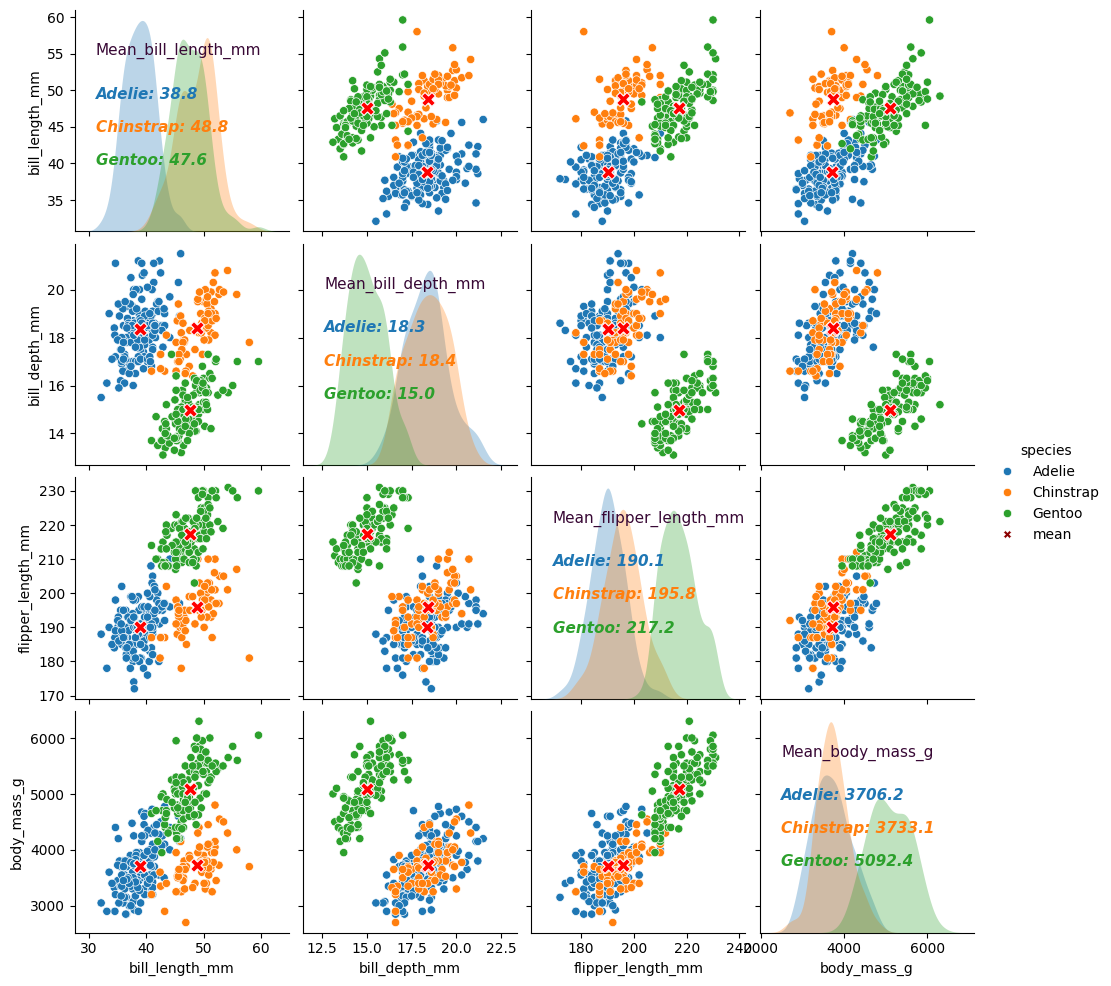

In [ ]:
# Построим парную диаграмму с помощью pairplot и добавим средние значения на график.

g = sns.pairplot(data=data_all,
                 hue='species',
                 diag_kind='None', # На диагональ добавим графики отдельно без средних значений
                 markers=['o', 'o', 'o', 'X'],
                 palette= sns.color_palette('tab10')[:3] + ['darkred'],  # по умолчанию palette='tab10'
                 )
# Добавим на диагональные элементы анотацию со средними значениями.
cmap_hue = dict(zip(g._hue_order[:3], sns.color_palette('tab10')[:3])) # Словарь устанавливает соответствие между species и цветом.
def annotate_func(*args, **kwargs):
  data = args[0]
  mean = data.mean()
  ax = plt.gca()
  # Каждое значения species из списка hue нужно записать с новой строки,
  # поэтому будем считать сколько экземпляров дочернего класса matplotlib.text.Annotation уже есть.
  # Можно считать экземпляры matplotlib.text.Text, но так как на графике уже есть подписи, то начальное значение не нулевое.
  n = len([c for c in ax.get_children() if isinstance(c, matplotlib.text.Annotation)])
  pos = (.1, .6 - .15*n)
  if n == 0:  # Добавим заглавие фичи для которой вычесляем среднее
    ax.text(.1,.85,
            f"Mean_{args[0].name}",
            size=11, weight='roman', stretch='condensed', color='xkcd:eggplant',
            va='top',  # По умолчанию ha='left' и va='bottom'
            transform=ax.transAxes
            )
  if kwargs['label'] in g._hue_order[:3]:  # Добавим среднее для всех species из фрейма, кроме mean.
    sns.kdeplot(data, fill=True, linewidth=0, alpha=0.3)  # Добавить график без заливки в качестве фона.
    ax.annotate(f"{kwargs['label']}: {mean:.1f}",
                size=11, style='oblique', weight='semibold',
                c=cmap_hue[kwargs['label']],
                xy=pos, xycoords=ax.transAxes
                )
g.map_diag(annotate_func)

# Настроим размер маркера среднего значения наложив диаграмму "поверх".
g.data = data_all[data_all.species == 'mean']
g.map_offdiag(func=sns.scatterplot,
              hue=None,  # Необходимо сбросить hue, чтобы маркеру среднего задать новые установки
              s=100, marker='X', color='r')

# *Кластеризация*

## Метод к-средних (KMeans)

In [ ]:
# Обучим модель KMeans на масштабированных данных
model_kmeans = KMeans(n_clusters=3,
                      # init=np.array(averages_sc), # Задание начальных центройдов, подставляем ср.знач. масшт. данных
                      # init=avg_data.drop(columns=['species']).to_numpy(),
                      random_state=12345).fit(data_scaled)

model_kmeans.cluster_centers_

array([[-1.04680889,  0.48662566, -0.88169491, -0.7627539 ],
       [ 0.65475809, -1.10270671,  1.16246305,  1.10121078],
       [ 0.67202511,  0.80526339, -0.28934658, -0.38410387]])

In [ ]:
# # Функция ошибки
# def fault(row: pd.DataFrame) -> str:
#   if row.species == row.label:
#     return row.species
#   else:
#     return 'fault'

# # Ниже используем лямбда функцию

In [ ]:
# Функцию поиска соответствия вида пингвина и номера кластера при котором достигается минимальное число ошибок.

def label_matching(df: pd.DataFrame) -> Tuple[Dict, int]:
  n_fault_min = len(df)
  for (a, b, c) in permutations([0, 1, 2]):
    data = df[['species', 'label']]
    matching = {a:"Adelie", b:"Chinstrap", c:"Gentoo"}
    data['label'] = data['label'].map(matching)
    data['accuracy'] = data.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)
    # data['accuracy'] = data.apply(fault, axis=1)  # Переписал через лямбда функцию
    n_fault = len(data[data['accuracy'] == 'fault'])
    if n_fault < n_fault_min:
      n_fault_min = n_fault
      dict_label_match = matching
  return dict_label_match, n_fault_min

In [ ]:
# Собираем датасет с результатами

data_kmeans = data_sc.copy(deep=True)
data_kmeans['label'] = model_kmeans.labels_
matching_kmeans = label_matching(data_kmeans)
data_kmeans['label'] = data_kmeans['label'].map(matching_kmeans[0])
data_kmeans['sex'] = penguins.sex

# Добавляем столбец с ошибками предсказания
# data_kmeans['accuracy'] = data_kmeans.apply(fault, axis=1)
data_kmeans['accuracy'] = data_kmeans.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)

# Добавляем строки со средними значениями
data_kmeans_avg = avg_data_sc.copy(deep=True)
data_kmeans_avg['label'] = 'mean'
data_kmeans_avg['accuracy'] = 'mean'
data_kmeans_avg['sex'] = 'center'
data_kmeans_all = pd.concat([data_kmeans, data_kmeans_avg], ignore_index=True)

# Добавляем строки с центройдами
centroids = pd.DataFrame(model_kmeans.cluster_centers_, columns=penguins_data.columns)
centroids['label'] = 'centroid' # ['0 centroid', '1 centroid', '2 centroid']
centroids['accuracy'] = 'centroid'
centroids['sex'] = 'center'
data_kmeans_all = pd.concat([data_kmeans_all, centroids], ignore_index=True)

# Количество ошибок отнесения к другому виду
n_fault_kmeans = len(data_kmeans[data_kmeans['accuracy'] == 'fault'])
print(f'Количество ошибок: {n_fault_kmeans}')  # n_fault_kmeans = order_kmeans[1]

# Строки с ошибками
# print(data_kmeans[data_kmeans['accuracy'] == 'fault'][['species', 'label', 'accuracy', 'sex']])

Количество ошибок: 27


In [ ]:
# Обучим модель KMeans на масштабированных данных и в качестве начальных центройдов зададим ср.зн.
model_kmeans_init = KMeans(n_clusters=3,
                      init=np.array(averages_sc), # Задание начальных центройдов, подставляем ср.знач. масшт. данных
                      random_state=12345).fit(data_scaled)

# Добавим к датасету столбец с результатами.

data_kmeans_init = data_sc.copy(deep=True)
data_kmeans_init['label'] = model_kmeans_init.labels_
matching_kmeans_init = label_matching(data_kmeans_init)
data_kmeans_init['label'] = data_kmeans_init['label'].map(matching_kmeans_init[0])

print(f'Количество ошибок модели с заданными начальными центройдами: {matching_kmeans_init[1]}')

Количество ошибок модели с заданными начальными центройдами: 12



*Заметки:*
При задании в качестве начальных центройдов средних значений число ошибок модели к-средних уменьшилось с 27 до 12, то есть точность возрасла более чем в 2 раза.

*Примечание:*
Для чистоты сравнения с другими методами кластеризации в дальнейшем будем использвать результаты модели к-средних без заданния начальных центройдов.

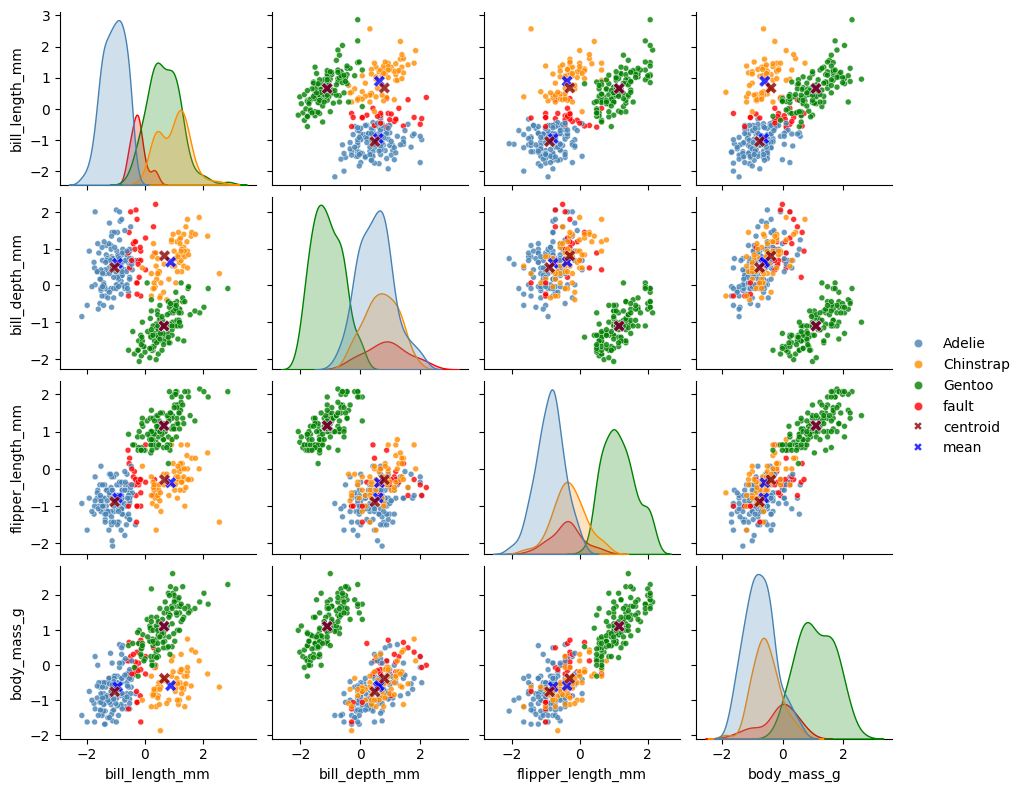

In [ ]:
# Построим парную диаграмму

g = sns.pairplot(data_kmeans_all,
                 hue='accuracy',
                 hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault', 'centroid', 'mean'],
                 diag_kind='None',
                 markers=['o', 'o', 'o', 'o', 'X', 'X'],
                 palette=['steelblue','darkorange','g', 'r', 'darkred', 'b'],
                 plot_kws=dict(alpha=.8,
                               size=data_kmeans_all.apply(lambda x: 100 if (x.accuracy=='mean')|(x.accuracy=='centroid') else 50, axis=1)  # Портится легенда.
                              ),
                 height=2
                 )
# Добавим на диагональные графики kdeplot, исключив средние значения и центройды.
g.map_diag(sns.kdeplot, fill=True,
           data=data_kmeans_all[(data_kmeans_all['accuracy']!='mean') & (data_kmeans_all['accuracy']!='centroid')],
           hue='accuracy'
           )

# Поправим легенду, убираем лишнее после параметризации размера маркера в plot_kws.
hue_names = g.hue_names  # Сохраняем данные легенды
g._legend.remove()  # Удаляем легенду
g.add_legend(label_order=hue_names[1:7], title='')  # Строим легенду заново, отбросив лишнее.

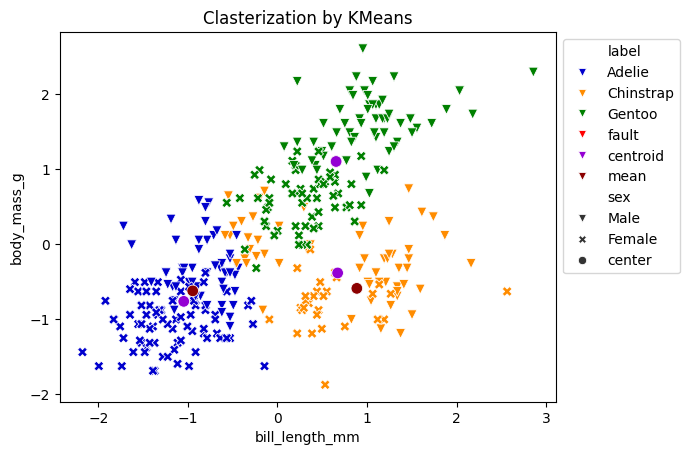

In [ ]:
# Построим диаграмму рассеяния

fig, ax = plt.subplots()
sns.scatterplot(x="bill_length_mm", y="body_mass_g",
                data=data_kmeans_all,
                hue="label",
                hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault', 'centroid', 'mean'],
                markers={'Female':'X', 'Male':'v', 'center':'o'},
                style="sex",
                palette=['mediumblue','darkorange','g', 'r', 'darkviolet', 'darkred'],
                # alpha=.8,
                size = [1]*333+[2]*6,
                sizes=(50,70)
                )
plt.title("Clasterization by KMeans")
h_kmeans, l_kmeans = ax.get_legend_handles_labels()
plt.legend(h_kmeans[:7]+h_kmeans[9:], l_kmeans[:7]+l_kmeans[9:], bbox_to_anchor=(1, 1))

##Расчет многоклассовых метрик accuracy, precision, recall, F1

*Статьи по теме:*
- https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii/ - отлично описана математика расчёта метрик;

In [ ]:
# Все три класса равнозначны, поэтому в качестве метрик можно использовать accuracy

accuracy_kmeans = (len(data_kmeans)-len(data_kmeans[data_kmeans['accuracy'] == 'fault']))/len(data_kmeans)
# Для очевидности расписанно data_kmeans[data_kmeans['accuracy'] == 'fault'], но в функции выше уже посчитанно: label_matching[1].

print(f'Для метода к-средних accuracy = {accuracy_kmeans:.3f}')

Для метода к-средних accuracy = 0.919


In [ ]:
# Расчёт precision, recall, F1-меры для многоклассовой классификации методами sklearn

matching_kmeans_reverse = {v:k for k, v in matching_kmeans[0].items()}  # Словарь для преобразования вида в номер класса

precision_kmeans = precision_score(penguins['species'].map(matching_kmeans_reverse),  # {"Adelie":0, "Gentoo":1, "Chinstrap":2}
                                   model_kmeans.labels_, average='macro')

recall_kmeans = recall_score(penguins['species'].map(matching_kmeans_reverse),
                             model_kmeans.labels_, average='macro')

f1_kmeans = f1_score(penguins['species'].map(matching_kmeans_reverse),
                     model_kmeans.labels_, average='macro')

print(f'Precision = {precision_kmeans:.3f}, '
      f'Recall = {recall_kmeans:.3f}, '
      f'F1 = {f1_kmeans:.3f}.')

Precision = 0.901, Recall = 0.925, F1 = 0.908.


In [ ]:
# Создадим таблицу с результатами

df_results = pd.DataFrame({'method': ['kmeans'],
                           'n_fault': [n_fault_kmeans],
                           'accuracy': [round(accuracy_kmeans, 3)],
                           'F1': [round(f1_kmeans, 3)]})
df_results

,method,n_fault,accuracy,F1
0,kmeans,27,0.919,0.908


In [ ]:
# Расчёт precision, recall, F1-меры без использования sklearn

# Расчёт precision

TP_adelie = len(data_kmeans[(data_kmeans['label'] == 'Adelie')&
                                    (data_kmeans['species'] == 'Adelie')])
FP_adelie = len(data_kmeans[data_kmeans['label'] == 'Adelie']) - TP_adelie

TP_gentoo = len(data_kmeans[(data_kmeans['label'] == 'Gentoo')&
                                    (data_kmeans['species'] == 'Gentoo')])
FP_gentoo = len(data_kmeans[data_kmeans['label'] == 'Gentoo']) - TP_gentoo

TP_chinstrap = len(data_kmeans[(data_kmeans['label'] == 'Chinstrap')&
                                    (data_kmeans['species'] == 'Chinstrap')])
FP_chinstrap = len(data_kmeans[data_kmeans['label'] == 'Chinstrap']) - TP_chinstrap

# precision_kmeans_micro = (TP_adelie + TP_gentoo + TP_chinstrap)/(TP_adelie + TP_gentoo + TP_chinstrap + FP_adelie + FP_gentoo + FP_chinstrap)
precision_kmeans_macro = (1/3)*(TP_adelie/(TP_adelie + FP_adelie) + TP_gentoo/(TP_gentoo + FP_gentoo) + TP_chinstrap/(TP_chinstrap + FP_chinstrap))

# Расчёт recall
FN_adelie = len(data_kmeans[data_kmeans['species'] == 'Adelie']) - TP_adelie
FN_gentoo = len(data_kmeans[data_kmeans['species'] == 'Gentoo']) - TP_gentoo
FN_chinstrap = len(data_kmeans[data_kmeans['species'] == 'Chinstrap']) - TP_chinstrap

recall_kmeans_macro = (1/3)*(TP_adelie/(TP_adelie + FN_adelie) + TP_gentoo/(TP_gentoo + FN_gentoo) + TP_chinstrap/(TP_chinstrap + FN_chinstrap))

# Расчёт F1-меры
f1_kmeans_macro = (1/3)*(TP_adelie/(TP_adelie + 0.5*(FP_adelie + FN_adelie)) +\
                         TP_gentoo/(TP_gentoo + 0.5*(FP_gentoo + FN_gentoo)) + \
                         TP_chinstrap/(TP_chinstrap + 0.5*(FP_chinstrap + FN_chinstrap)))

print(f'Precision = {precision_kmeans_macro:.3f}, '
      f'Recall = {recall_kmeans_macro:.3f}, '
      f'F1 = {f1_kmeans_macro:.3f}.')


Precision = 0.901, Recall = 0.925, F1 = 0.908.


*Заметки:*
- Метод k-средних без ошибок выделил Gentoo в одельную группу, а вот между Adelie и Chinstrap 27 ошибок (в основном парни Adelie были отнесены к Chinstrap);
- Для Adelie и Chinstrap центройды заметно смещены от средних значений.

___

##KMeans + t-SNE

*Заметки*: На прямую не собрать конвейер pipeline = make_pipeline(TSNE(), KMeans()) так как он выполняет процедуру fit_transform только в конце, а для TSNE тоже необходимо вызывать fit_transform. Поэтому создадим класс tsne_fit_transformer, у которого будет метод fit_transform.


*Статья* по теме интегрирования функции и классов в пайплайн -
* https://habr.com/ru/companies/skillfactory/articles/675876
* https://scikit-learn.ru/6-1-pipelines-and-composite-estimators/

In [ ]:
# Cоздадим класс tsne_fit_transformer c методом fit_transform.

class tsne_fit_transformer(BaseEstimator, TransformerMixin):
  def __init__(self, n_components, perplexity, early_exaggeration, random_state=None):
    self.n_components = n_components
    self.perplexity = perplexity
    self.early_exaggeration = early_exaggeration
    self.random_state = random_state
    # self.tsne = TSNE(n_components=self.n_components,
    #             perplexity=self.perplexity,
    #             early_exaggeration=self.early_exaggeration,
    #             random_state=self.random_state)

  def fit(self, X, y = None):
    tsne = TSNE(n_components=self.n_components,
                perplexity=self.perplexity,
                early_exaggeration=self.early_exaggeration,
                random_state=self.random_state)
    self.X = tsne.fit_transform(X)
    # self.X = self.tsne.fit_transform(X)  # TSNE не имеет отдельного метода transform
    return self  # Позволяет делать цепочные вызовы функций

  def transform(self, X, y = None):
    return self.X

In [ ]:
# Собираем pipeline

pipe_kmeans_tsne = make_pipeline(tsne_fit_transformer(n_components=2, # по умолчанию
                                                      perplexity=10,  # по умолчанию
                                                      early_exaggeration=25,  # по умолчанию
                                                      random_state=12345),
                                  KMeans(n_clusters=3,
                                         random_state=12345)
                                  )
clustering_kmeans_tsne = pipe_kmeans_tsne.fit_transform(data_scaled)

pipe_kmeans_tsne.named_steps['kmeans'].cluster_centers_

array([[-42.49918  ,   8.747703 ],
       [ 41.10517  , -23.429169 ],
       [ 10.442824 ,   3.4563642]], dtype=float32)

In [ ]:
# Собирем таблицу с данными после tsne преобразования.

data_tsne = pd.DataFrame(pipe_kmeans_tsne.named_steps['tsne_fit_transformer'].X,
                         columns=["feature_1", "feature_2"])
data_tsne['species'] = penguins.species
data_tsne['sex'] = penguins.sex

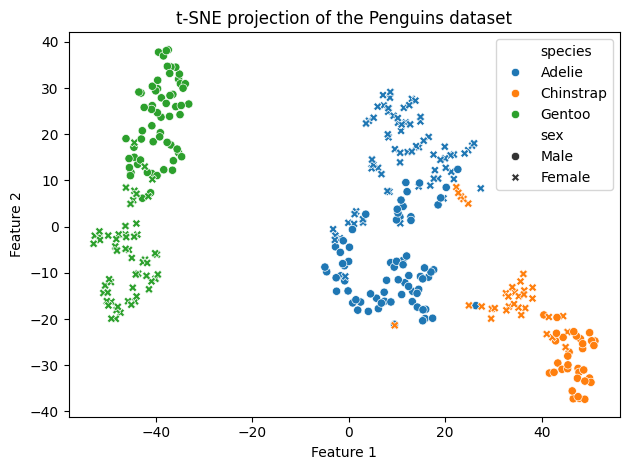

In [ ]:
# Постороим диаграмму рассеяния для пары признаков F1 и F2.

sns.scatterplot(x="feature_1", y="feature_2",
                data=data_tsne,
                hue="species",
                style="sex",
                )
plt.title("t-SNE projection of the Penguins dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()

In [ ]:
# Собираем датасет с результатами
data_kmeans_tsne = data_tsne.copy(deep=True)
data_kmeans_tsne['label'] = pipe_kmeans_tsne.named_steps['kmeans'].labels_
matching_kmeans_tsne = label_matching(data_kmeans_tsne)
data_kmeans_tsne['label'] = data_kmeans_tsne['label'].map(matching_kmeans_tsne[0])

# Добавим столбец с ошибками предсказания
data_kmeans_tsne['accuracy'] = data_kmeans_tsne.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)

# Количество ошибок
print(f'Количество ошибок: {matching_kmeans_tsne[1]}')

# Строки с ошибками
# print(data_kmeans_tsne[data_kmeans_tsne['accuracy'] == 'fault'][['species', 'label', 'accuracy', 'sex']])

Количество ошибок: 8


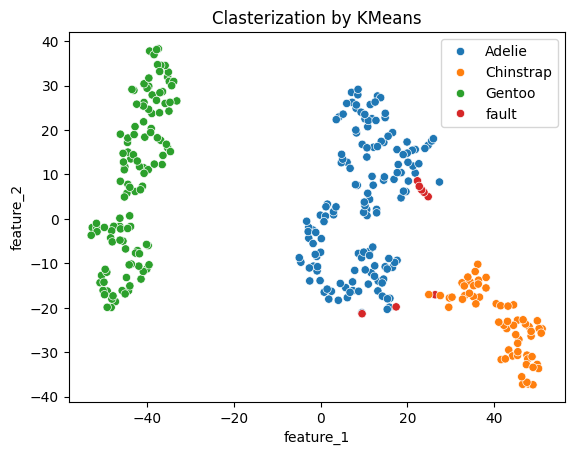

In [ ]:
# Построим диаграмму рассеяния

fig, ax = plt.subplots()
sns.scatterplot(x="feature_1", y="feature_2",
                data=data_kmeans_tsne,
                hue="accuracy",
                hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault']
                )
plt.title("Clasterization by KMeans")
ax.legend()
h_kmeans_tsne, l_kmeans_tsne = ax.get_legend_handles_labels()

*Примечание:* ниже тот же результат без использования pipeline.

In [ ]:
# # Сократим размерность данных с 4 до 2, применив метод t-SNE к масштабированным данным.
# reducer_tsne = TSNE(n_components=2, # по умолчанию
#                     perplexity=30,  # по умолчанию
#                     early_exaggeration=12,  # по умолчанию
#                     random_state=12345
#                     )
# dimension_tsne = reducer_tsne.fit_transform(data_scaled)

# # Собирем таблицу с преобразованными данными.
# data_tsne = pd.DataFrame(dimension_tsne, columns=["feature_1", "feature_2"])
# data_tsne['species'] = penguins.species
# data_tsne['sex'] = penguins.sex

# # Постороим диаграмму рассеяния для пары признаков F1 и F2.
# sns.scatterplot(x="feature_1", y="feature_2",
#                 data=data_tsne,
#                 hue="species",
#                 style="sex",
#                 )
# plt.title("t-SNE projection of the Penguins dataset")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.tight_layout()
# plt.show()

In [ ]:
# # Обучим модель KMeans на данных после t-SNE.
# model_kmeans_tsne = KMeans(n_clusters=3,
#                            random_state=12345).fit(dimension_tsne)

# model_kmeans_tsne.cluster_centers_

# # Собираем датасет с результатами
# data_kmeans_tsne = data_tsne.copy(deep=True)
# data_kmeans_tsne['label'] = model_kmeans_tsne.labels_
# matching_kmeans_tsne = label_matching(data_kmeans_tsne)
# data_kmeans_tsne['label'] = data_kmeans_tsne['label'].map(matching_kmeans_tsne[0])

# # Добавим столбец с ошибками предсказания
# data_kmeans_tsne['accuracy'] = data_kmeans_tsne.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)

# # Количество ошибок
# print(f'Количество ошибок: {matching_kmeans_tsne[1]}')

# # Строки с ошибками
# # print(data_kmeans_tsne[data_kmeans_tsne['accuracy'] == 'fault'][['species', 'label', 'accuracy', 'sex']])

# # Построим диаграмму рассеяния
# fig, ax = plt.subplots()
# sns.scatterplot(x="feature_1", y="feature_2",
#                 data=data_kmeans_tsne,
#                 hue="accuracy",
#                 hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault']
#                 )
# plt.title("Clasterization by KMeans")
# ax.legend()
# h_kmeans_tsne, l_kmeans_tsne = ax.get_legend_handles_labels()

### Перебор гиперпараметров алгоритма t-SNE

   early_exaggeration  perplexity  n_fault  accuracy     F1
0                12.0        10.0      7.0     0.979  0.974
1                25.0        10.0      8.0     0.976  0.971
3                25.0        30.0     12.0     0.964  0.957
4                12.0        50.0     12.0     0.964  0.957
2                12.0        30.0     27.0     0.919  0.908
5                25.0        50.0     27.0     0.919  0.908


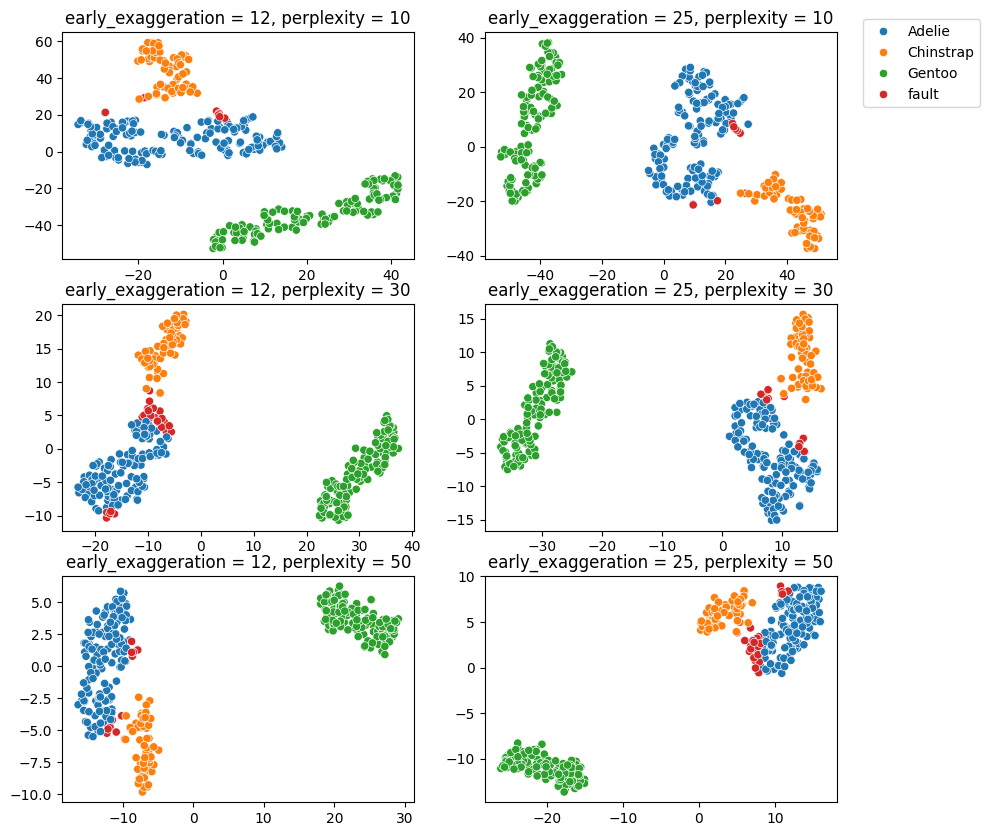

In [ ]:
# Перебор параметров алгоритма t-SNE
pipe_par = make_pipeline(tsne_fit_transformer(n_components=2,
                                              perplexity=30,
                                              early_exaggeration=12,
                                              random_state=12345),
                          KMeans(n_clusters=3,
                                 random_state=12345)
                          )
results_par = pd.DataFrame(columns=['early_exaggeration', 'perplexity', 'n_fault', 'accuracy', 'F1'])
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
len_data = len(data_scaled)
for i, perplexity in enumerate([10, 30, 50]):  # Учитывает число соседей (высокое значение подчеркивает глобальную структуру, низкое - локальную).
  for j, early_exaggeration in enumerate([12, 25]):
    # pipe_par = make_pipeline(tsne_fit_transformer(n_components=2,
    #                                           perplexity=perplexity,
    #                                           early_exaggeration=early_exaggeration,
    #                                           random_state=12345),
    #                          KMeans(n_clusters=3,
    #                                 random_state=12345)
    #                          )
    pipe_par.set_params(tsne_fit_transformer__perplexity=perplexity,
                        tsne_fit_transformer__early_exaggeration=early_exaggeration)
    clustering_par = pipe_par.fit_transform(data_scaled)

    # Собираем таблицу с новыми признаками
    data_par = pd.DataFrame(pipe_par.named_steps['tsne_fit_transformer'].X,
                            columns=["feature_1", "feature_2"])
    data_par['species'] = penguins.species
    # Добавляем к таблице результаты кластеризации.
    data_par['label'] = pipe_par.named_steps['kmeans'].labels_
    matching_par = label_matching(data_par)
    data_par['label'] = data_par['label'].map(matching_par[0])
    # Добавляем столбец с ошибками предсказания
    data_par['accuracy'] = data_par.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)

    # Строим диаграму рассеяния.
    sns.scatterplot(ax=axes[i, j],
                    x="feature_1", y="feature_2",
                    data=data_par,
                    hue="accuracy",
                    hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault'],
                    legend=None)
    axes[i, j].set_title(f'early_exaggeration = {early_exaggeration}, perplexity = {perplexity}',
                         fontdict={'fontsize':12})
    axes[i, j].set(xlabel=None, ylabel=None)
    # Вычисляем метрику accuracy
    accuracy_par = (len_data - matching_par[1])/len_data
    # Вычисляем метрику f1
    matching_par_reverse = {v:k for k, v in matching_par[0].items()}
    f1_par = f1_score(penguins['species'].map(matching_par_reverse),
                      pipe_par.named_steps['kmeans'].labels_, average='macro')
    # Записываем результаты в таблицу
    results_par.loc[len(results_par.index)] = [early_exaggeration, perplexity, matching_par[1],
                                               round(accuracy_par, 3), round(f1_par, 3)]
print(results_par.sort_values(by='n_fault'))
fig.legend(h_kmeans_tsne, l_kmeans_tsne, bbox_to_anchor=(1.05, 0.9))  # Параметры (h, l) для легенды определены на диаграмме выше.

*Заметки:*
* Если в классе tsne_fit_transformer определить self.tsne в `__init__`, тогда при переборе гиперпараметров pipeline нужно объявить внутри цикла.
```
class tsne_fit_transformer(BaseEstimator, TransformerMixin):
  def __init__(self, n_components, perplexity, early_exaggeration, random_state=None):
    self.n_components = n_components
    self.perplexity = perplexity
    self.early_exaggeration = early_exaggeration
    self.random_state = random_state
    self.tsne = TSNE(n_components=self.n_components,
                perplexity=self.perplexity,
                early_exaggeration=self.early_exaggeration,
                random_state=self.random_state)
    
  def fit(self, X, y = None):
    self.X = self.tsne.fit_transform(X)  
    return self  

  def transform(self, X, y = None):
    return self.X
```
```
for i, perplexity in enumerate([10, 30, 50]):
  for j, early_exaggeration in enumerate([12, 25]):
    pipe_par = make_pipeline(tsne_fit_transformer(n_components=2,
                                              perplexity=perplexity,
                                              early_exaggeration=early_exaggeration,
                                              random_state=12345),
                              KMeans(n_clusters=3,
                                    
                                     random_state=12345)
                              )
```
* Если в классе tsne_fit_transformer определяем tsne внутри метода fit, тогда при переборе гиперпараметров pipeline можно объявить до цикла и использовать метод set_params внутри цикла.

```
class tsne_fit_transformer(BaseEstimator, TransformerMixin):
  def __init__(self, n_components, perplexity, early_exaggeration, random_state=None):
    self.n_components = n_components
    self.perplexity = perplexity
    self.early_exaggeration = early_exaggeration
    self.random_state = random_state
    
  def fit(self, X, y = None):
    tsne = TSNE(n_components=self.n_components,
                perplexity=self.perplexity,
                early_exaggeration=self.early_exaggeration,
                random_state=self.random_state)
    self.X = tsne.fit_transform(X)
    return self

  def transform(self, X, y = None):
    return self.X
pipe_par = make_pipeline(tsne_fit_transformer(n_components=2,
                                              perplexity=30,
                                              early_exaggeration=12,
                                              random_state=12345),
                          KMeans(n_clusters=3,
                                 random_state=12345)
                          )
```
```
for i, perplexity in enumerate([10, 30, 50]):
  for j, early_exaggeration in enumerate([12, 25]):
    pipe_par.set_params(tsne_fit_transformer__perplexity=perplexity,
                        tsne_fit_transformer__early_exaggeration=early_exaggeration)
    clustering_par = pipe_par.fit_transform(data_scaled)
```

*Примечание:* ниже тот же результат без использования pipeline.

In [ ]:
# # Перебор параметров алгоритма t-SNE

# results_par = pd.DataFrame(columns=['early_exaggeration', 'perplexity', 'n_fault', 'accuracy', 'F1'])
# fig, axes = plt.subplots(3, 2, figsize=(10, 10))
# len_data = len(data_scaled)
# for i, perplexity in enumerate([10, 30, 50]):  # Учитывает число соседей (высокое значение подчеркивает глобальную структуру, низкое - локальную).
#   for j, early_exaggeration in enumerate([12, 25]):
#     # Уменьшим размерность с 4 до 2 признаков.
#     reducer_par = TSNE(n_components=2,
#                        perplexity=perplexity,
#                        early_exaggeration=early_exaggeration,
#                        random_state=12345).\
#                        fit_transform(data_scaled)
#     # Собираем таблицу с новыми признаками.
#     data_par = pd.DataFrame(reducer_par, columns=["feature_1", "feature_2"])

#     data_par['species'] = penguins.species
#     # Обучим модель KMeans на данных t-SNE.
#     kmeans_par = KMeans(n_clusters=3,
#                         random_state=12345).fit(reducer_par)
#     # Добавлем к таблице результаты кластеризации.
#     data_par['label'] = kmeans_par.labels_
#     matching_par = label_matching(data_par)
#     data_par['label'] = data_par['label'].map(matching_par[0])
#     # Добавим столбец с ошибками предсказания
#     data_par['accuracy'] = data_par.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)

#     # Строим диаграму рассеяния.
#     sns.scatterplot(ax=axes[i, j],
#                     x="feature_1", y="feature_2",
#                     data=data_par,
#                     hue="accuracy",
#                     hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault'],
#                     legend=None)
#     axes[i, j].set_title(f'early_exaggeration = {early_exaggeration}, perplexity = {perplexity}',
#                          fontdict={'fontsize':12})
#     axes[i, j].set(xlabel=None, ylabel=None)
#     # Вычисляем метрику accuracy
#     accuracy_par = (len_data - matching_par[1])/len_data
#     # Вычисляем метрику f1
#     matching_par_reverse = {v:k for k, v in matching_par[0].items()}
#     f1_par = f1_score(penguins['species'].map(matching_par_reverse),
#                       kmeans_par.labels_, average='macro')
#     # Записываем результаты в таблицу
#     results_par.loc[len(results_par.index)] = [early_exaggeration, perplexity, matching_par[1],
#                                                round(accuracy_par, 3), round(f1_par, 3)]
# print(results_par.sort_values(by='n_fault'))
# fig.legend(h_kmeans_tsne, l_kmeans_tsne, bbox_to_anchor=(1.05, 0.9))  # Параметры (h, l) для легенды определены на диаграмме выше.

In [ ]:
# Добавим лучший результат параметризации к таблице с результатами.
best_result_par = results_par.sort_values(by='n_fault').loc[0]
df_results.loc[len(df_results.index)] = {'method': 'kmeans+tsne',
                           'n_fault': best_result_par[2],
                           'accuracy': best_result_par[3],
                           'F1': best_result_par[4]}
df_results

,method,n_fault,accuracy,F1
0,kmeans,27.0,0.919,0.908
1,kmeans+tsne,7.0,0.979,0.974


*Заметки:*
- Использование метода уменьшения размерности данных t-SNE перед кластеризацией KMeans приводит к уменьшению числа ошибок и повышению точности, но результаты сильно зависят от выбора гиперпараметро t-SNE (У лучшей модели 7 ошибок, а у худшей - 27,  столько же сколько у модели без использования t-SNE);
- С ростом величины perplexity группы точек становятся плотнее и точность разделения близких групп на кластеры падает. Это объясняется тем, что этот гиперпараметр отвечает за число соседей и высокое значение подчеркивает глобальную структуру;
- Явной зависимости точности результатов от гиперпараметра early_exaggeration не наблюдается.

___

## Агломеративный метод (Hierarchical agglomerative clustering)

In [ ]:
# Обучим модель Agglomerative Clustering на масштабированных данных

model_agg = AgglomerativeClustering(n_clusters=3,
                                    linkage='ward'  # по умолчанию
                                    ).fit_predict(data_sc.drop('species', axis=1))

In [ ]:
# Собираем датасет
data_agg = data_sc.copy(deep=True)
data_agg['label'] = model_agg
matching_agg = label_matching(data_agg)
data_agg['label'] = data_agg['label'].map(matching_agg[0])  # Соответствие подобрано вручную
data_agg['sex'] = penguins.sex

# Добавим столбец с ошибками предсказания
data_agg['accuracy'] = data_agg.apply(lambda x: x.species if x.species==x.label else 'fault', axis=1)

# Строки с ошибками
# print(data_agg[data_agg['accuracy'] == 'fault'][['species', 'label', 'accuracy', 'sex']])

print(f'Количество ошибок: {matching_agg[1]}')

Количество ошибок: 11


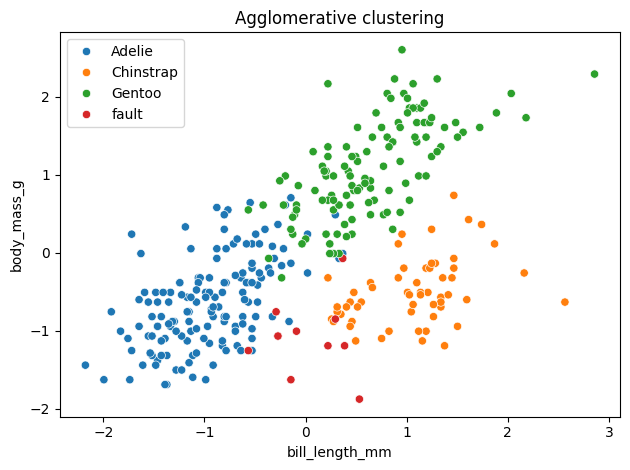

In [ ]:
# Построим диаграмму рассеяния

sns.scatterplot(x="bill_length_mm", y="body_mass_g",
                data=data_agg,
                hue="accuracy",
                hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault'],
                # style="sex",
                # markers={'Female':'X', 'Male':'v'}
                )
plt.title("Agglomerative clustering")
plt.legend()

plt.tight_layout()
plt.show()

*Заметки:*
- Агломеративный метод также без ошибок выделил Gentoo в одельную группу, а вот между Adelie и Chinstrap 11 ошибок (девчонки Chinstrap отнесены к Adelie).

Text(252.0, 15, 'три кластера')

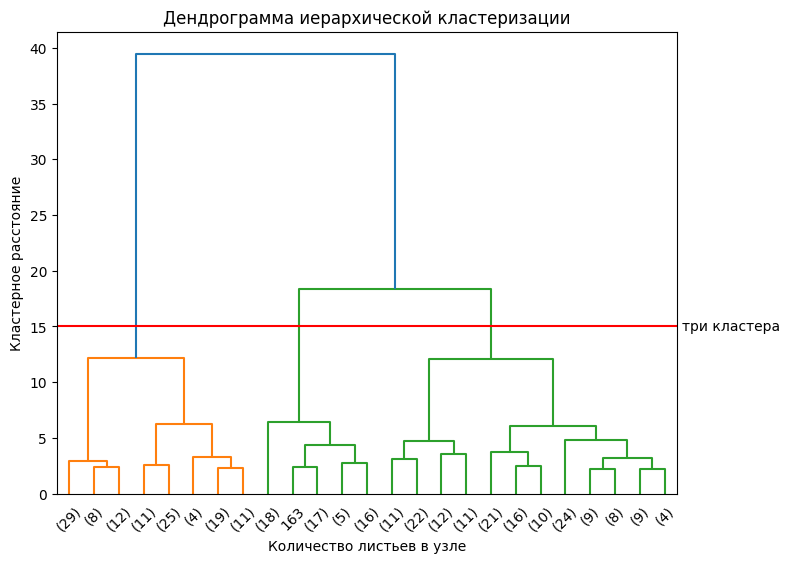

In [ ]:
# Построение дендрограммы

clusters = hierarchy.linkage(data_sc.drop('species', axis=1), method='ward')
plt.figure(figsize=(8,6))
dendogram = hierarchy.dendrogram(clusters,
                                 p=25,
                                 truncate_mode='lastp'
                                 )
plt.axhline(15, c='r')
plt.title("Дендрограмма иерархической кластеризации")
plt.xlabel("Количество листьев в узле")
plt.ylabel("Кластерное расстояние")
ax = plt.gca()
bounds = ax.get_xbound()
ax.text(bounds[1]+2, 15, 'три кластера', va='center', fontdict={'size': 10})

In [ ]:
# Расчёт accuracy, precision, recall, F1-меры

matching_agg_reverse = {v:k for k, v in matching_agg[0].items()}  # Словарь для преобразования вида в номер класса {"Adelie":1, "Gentoo":0, "Chinstrap":2}

accuracy_agg = (len(data_agg)-len(data_agg[data_agg['accuracy'] == 'fault']))/len(data_agg)

f1_agg = f1_score(penguins['species'].map(matching_agg_reverse),
                  model_agg, average='macro')

# precision_agg = precision_score(penguins['species'].map(matching_agg_reverse),
#                                 model_agg, average='macro')

# recall_agg = recall_score(penguins['species'].map(matching_agg_reverse),
#                           model_agg, average='macro')

print(f'Accuracy = {accuracy_agg:.3f}, '
      # f'Precision = {precision_agg:.3f}, '
      # f'Recall = {recall_agg:.3f}, '
      f'F1 = {f1_agg:.3f}.')

Accuracy = 0.967, F1 = 0.959.


In [ ]:
# Добавим данные в таблицу с результатами
df_results.loc[len(df_results.index)] = {'method': 'agglomerative',
                                         'n_fault': matching_agg[1],
                                         'accuracy': round(accuracy_agg, 3),
                                         'F1': round(f1_agg, 3)}
df_results

,method,n_fault,accuracy,F1
0,kmeans,27.0,0.919,0.908
1,kmeans+tsne,7.0,0.979,0.974
2,agglomerative,11.0,0.967,0.959


___

## DBSCAN (Density-based spatial clustering of applications with noise)

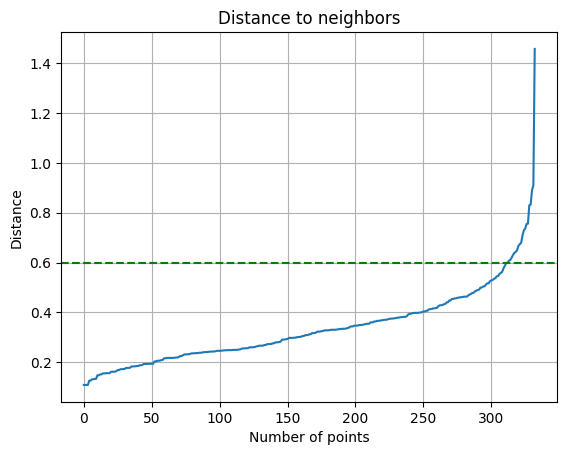

In [ ]:
# Определим гиперпараметр расстояния eps в DBSCAN, используя метод поиска ближайшего соседа.

neighbors = NearestNeighbors(n_neighbors=2).fit(data_sc.drop('species', axis=1))

distance, indices = neighbors.kneighbors(data_sc.drop('species', axis=1))
plt.plot(sorted(distance[:, 1]))
plt.grid()
plt.title("Distance to neighbors")
plt.xlabel('Number of points')
plt.ylabel("Distance")
plt.axhline(y=0.6, color='g', linestyle='dashed')

In [ ]:
# Обучим модель DBSCAN на масштабированных данных

clustering_dbscan = DBSCAN(eps=0.6, # по умолчанию 0.5, график выше имеет линейный участок примерно до 0.6
                           min_samples=8,  # по умолчанию 5, обычно этот параметр равен 2*размерность
                           metric='euclidean' # по умолчанию 'euclidean'
                           ).fit(data_sc.drop('species', axis=1))

# Сейчас без pipeline, данные уже масштабировали
# pipe_dbscan = make_pipeline(StandardScaler(), DBSCAN(eps=0.6, min_samples=8))
# clustering_dbscan = pipe_dbscan.fit(penguins_data)
# n_clusters = set(clustering_dbscan.named_steps['dbscan'].labels_)  # -1 означает, что точка не относится ни к одному кластеру

n_clusters = set(clustering_dbscan.labels_)  # -1 означает, что точка не относится ни к одному кластеру

print('Число кластеров: ', len(n_clusters) - 1)  # Отнимаем 1 кластер - это точки без кластера.

Число кластеров:  3


In [ ]:
# Функция ошибки

def fault_dbscan(row):
  if row.label == row.species:
    return row.species
  elif row.label == 'unlabeled':
    return 'unlabeled'
  else:
    return 'fault'

In [ ]:
# Фунция соответствия labels и species.

def label_match_dbscan(df: pd.DataFrame) -> Tuple[Dict, int, int]:
  n_fault_min = len(df)
  dict_label_match = None
  for (a, b, c) in permutations([0, 1, 2]):
    data = df[['species', 'label']]
    matching = {a: "Adelie", b: "Chinstrap", c: "Gentoo", -1: "unlabeled"}
    data['label'] = data['label'].map(matching)
    data['accuracy'] = data.apply(fault_dbscan, axis=1)
        # Можно использовать лямбда функцию, но условие выглядит громозко.
    # data['accuracy'] = data.apply(lambda x: x.species if x.species==x.label
    #                               else ('unlabeled' if x.label=="unlabeled" else 'fault'), axis=1)
    n_fault = len(data[data['accuracy'] == "fault"])
    n_noise = len(data[data['label'] == "unlabeled"])
    if n_fault < n_fault_min:
      n_fault_min = n_fault
      dict_label_match = matching
  return dict_label_match, n_fault_min, n_noise

In [ ]:
#  Cобирём данные в таблицу

data_dbscan = penguins_data.copy(deep=True)
data_dbscan['label'] = clustering_dbscan.labels_  # Добавление столбца с номером кластера
data_dbscan['species'] = penguins.species
matching_dbscan = label_match_dbscan(data_dbscan)
data_dbscan['label'] = data_dbscan['label'].map(matching_dbscan[0])
data_dbscan['sex'] = penguins.sex

# Добавим столбец с ошибками предсказания
data_dbscan['accuracy'] = data_dbscan.apply(fault_dbscan, axis=1)
# Можно использовать лямбда функцию, но условие выглядит громозко.
# data_dbscan['accuracy'] = data_dbscan.apply(lambda x: x.species if x.label==x.species
#                                             else ('unlabeled' if x.label=="unlabeled" else 'fault'), axis=1)

# Строки с ошибками
# print(data_dbscan[data_dbscan['accuracy'] == "fault"][['species', 'label', 'accuracy', 'sex']])

print(f'Количество ошибок: {matching_dbscan[1]} ({matching_dbscan[1]/len(data_dbscan):0.2f}%)')
print(f'Количество точек без кластера: {matching_dbscan[2]} ({matching_dbscan[2]/len(data_dbscan):0.2f}%)')

Количество ошибок: 6 (0.02%)
Количество точек без кластера: 45 (0.14%)


Text(0.5, 1.0, 'Clasterization by DBSCAN')

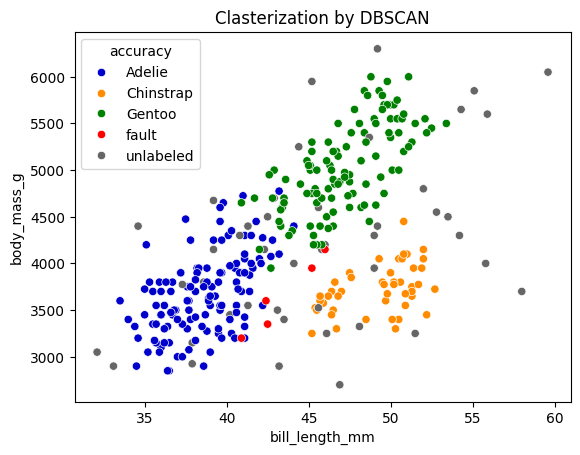

In [ ]:
# Построим диаграмму рассеяния
sns.scatterplot(x="bill_length_mm", y="body_mass_g",
                data=data_dbscan,
                hue="accuracy",
                hue_order=['Adelie', 'Chinstrap', 'Gentoo', 'fault', 'unlabeled'],
                # style="sex",
                # markers={'Female':'X', 'Male':'v'},
                palette=['mediumblue','darkorange','g', 'r', '0.4'],
                )
plt.title("Clasterization by DBSCAN")

*Заметки:*
- У DBSCAN  всего 5 ошибок отнесения к кластеру и все они на границе кластеров, но очень много точек без кластера и разбросаны они как по краям так и внутри кластеров.

In [ ]:
# Вычислим метрику accuracy, маркеры без кластера считаем за ошибку.

n_fault_dbscan = matching_dbscan[1]
n_noise_dbscan = matching_dbscan[2]
accuracy_dbscan = (len(data_dbscan)-(n_fault_dbscan + n_noise_dbscan))/len(data_dbscan)

# accuracy_dbscan = (len(data_dbscan)-len(data_dbscan[(data_dbscan['accuracy'] == 'fault') | (data_dbscan['accuracy'] == 'noise')]))/len(data_dbscan)

print(f'Accuracy = {accuracy_dbscan:.3f}')

# Добавим данные в таблицу с результатами
df_results.loc[len(df_results.index)] = {'method': 'dbscan',
                                         'n_fault': n_fault_dbscan + n_noise_dbscan,
                                         'accuracy': round(accuracy_dbscan, 3),
                                         'F1': '-'}

Accuracy = 0.847


____

### Перебор гиперпараметров DBSCAN

In [ ]:
dbscan_results = pd.DataFrame(columns=['eps', 'min_samples', 'n_clusters', 'n_unlabeled', 'fault', 'accuracy'])
for eps in [i/10 for i in range(4, 9, 1)]:
  for min_samples in range(4, 14, 1):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data_sc.drop('species', axis=1))
    n_clusters = len(set(dbscan.labels_))-1
    n_unlabeled = list(dbscan.labels_).count(-1)
    if n_clusters == 3:
      data_dbscan = penguins_data.copy(deep=True)
      data_dbscan['label'] = dbscan.labels_
      data_dbscan['species'] = penguins.species
      matching_dbscan = label_match_dbscan(data_dbscan)
      fault = matching_dbscan[1]
      accuracy = round((len(data_dbscan)-(fault + n_unlabeled))/len(data_dbscan), 2)
    else:
      fault = None
      accuracy = None

    # Добавим данные в таблицу с результатами
    dbscan_results.loc[len(dbscan_results.index)] = {'eps': eps,
                                                     'min_samples': min_samples,
                                                     'n_clusters': n_clusters,
                                                     'n_unlabeled': n_unlabeled,
                                                     'fault': fault,
                                                     'accuracy': accuracy}

# Собирем сводную таблицу для результатов с тремя кластерами.
pd.pivot_table(dbscan_results[dbscan_results.n_clusters == 3], index=['n_clusters', 'eps', 'min_samples'])

accuracy fault  n_unlabeled
n_clusters eps min_samples                             
3          0.4 9                0.06  26.0          287
           0.5 11               0.47   4.0          173
           0.6 7                0.85   8.0           41
               8                0.85   6.0           45
               9                0.84   6.0           48
           0.7 4                0.78  60.0           12
               12               0.89   8.0           29
               13               0.87   8.0           34

*Заметки:*
- Из таблицы видно, что изначально были выбраны оптимальные значения гиперпараметров (eps=0.6, min_samples=8) при которых dbscan выделил 3 кластера и сумма ошибок n_unlabeled и fault близка к минимальным значениям (accuracy = 0.85).
- Перебор гиперпараметров не показал заметного роста accuracy (максимум accuracy = 0.89 наблюдается при eps=0.7 и min_samples=12), количество точек без кластера тоже остается большим.

___

## Результаты

In [ ]:
df_results

,method,n_fault,accuracy,F1
0,kmeans,27.0,0.919,0.908
1,kmeans+tsne,7.0,0.979,0.974
2,agglomerative,11.0,0.967,0.959
3,dbscan,51.0,0.847,-


*Выводы:*
- Лучшие результаты показал метод k-средних в паре с методом уменьшения размерности данных t-SNE, также агломеративный метод даёт хорошие результаты.